In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from torch import nn

from tinyai.core import set_output
from tinyai.learner import TrainLearner
from tinyai.training import cross_entropy

set_output()

In [ ]:
from datasets import load_dataset
import torchvision.transforms.functional as TF

from tinyai.core import inplace
from tinyai.datasets import DataLoaders
from tinyai.training import cross_entropy

dsd = load_dataset("daloopa/fashion-mnist-interview")

x,y = 'image','label'

@inplace
def transformi(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

bs = 1024
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, batch_size=bs)

In [ ]:
from tinyai.conv import conv

def get_model():
    return nn.Sequential(
        conv(1,8),
        conv(8, 16),
        conv(16, 32),
        conv(32,64),
        conv(64, 10, act=False),
        nn.Flatten()
    )


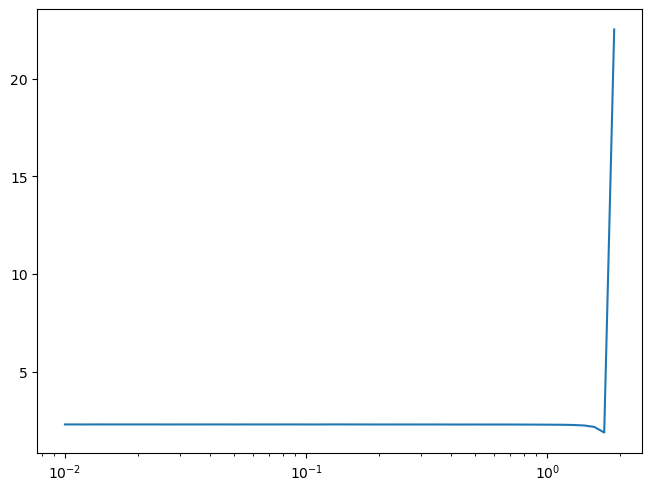

In [ ]:
learn = TrainLearner(get_model(), dls, loss_func=cross_entropy, lr=1e-4)
learn.lr_find(gamma=1.1, start_lr=1e-2)

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from tinyai.learner import MetricsCB
from tinyai.activations import ActivationStats
import fastcore.all as fc

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [metrics, astats]
learn = TrainLearner(get_model(), dls, loss_func=cross_entropy, lr=0.2, cbs=cbs)


Epoch,Train,Loss,accuracy
0,eval,1.7113,0.5125
1,eval,0.8560,0.6765
2,eval,0.6766,0.7545
3,eval,0.6335,0.7623


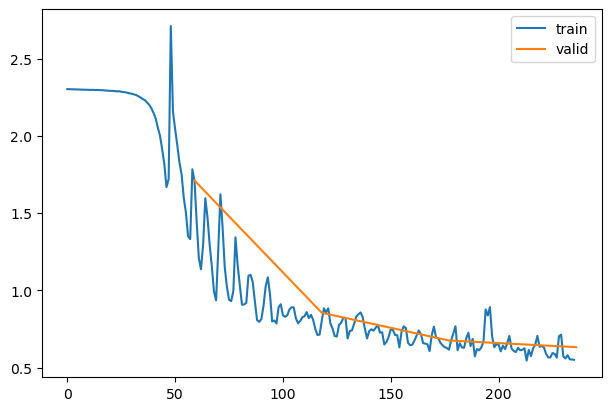

In [ ]:
learn.fit(4)

In [ ]:
from tinyai.core import clean_mem
clean_mem()

### 0.4

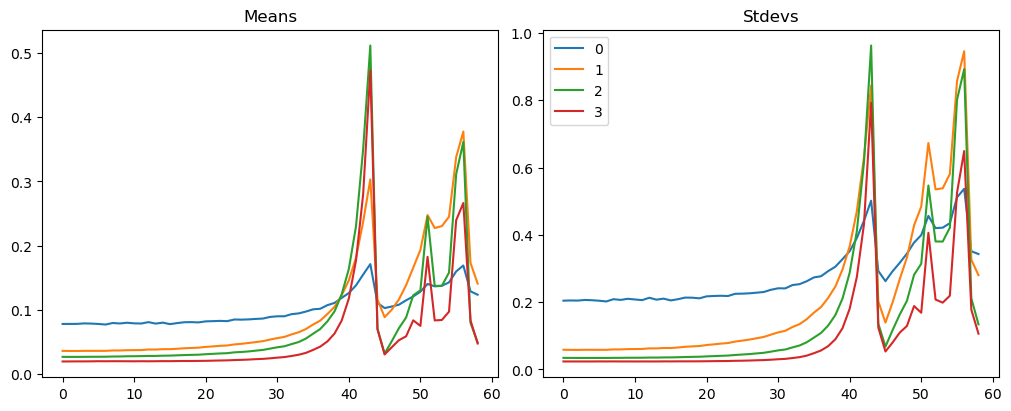

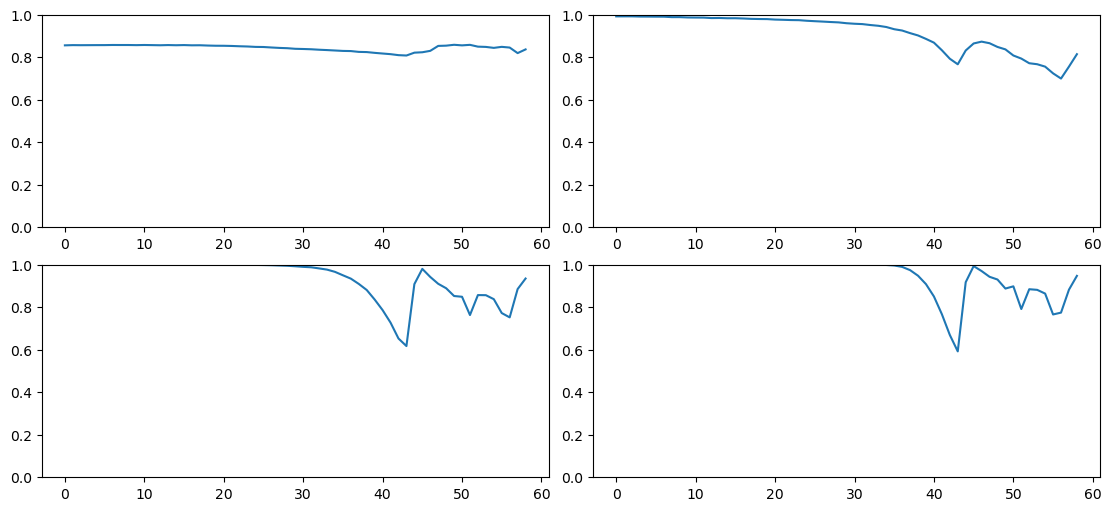

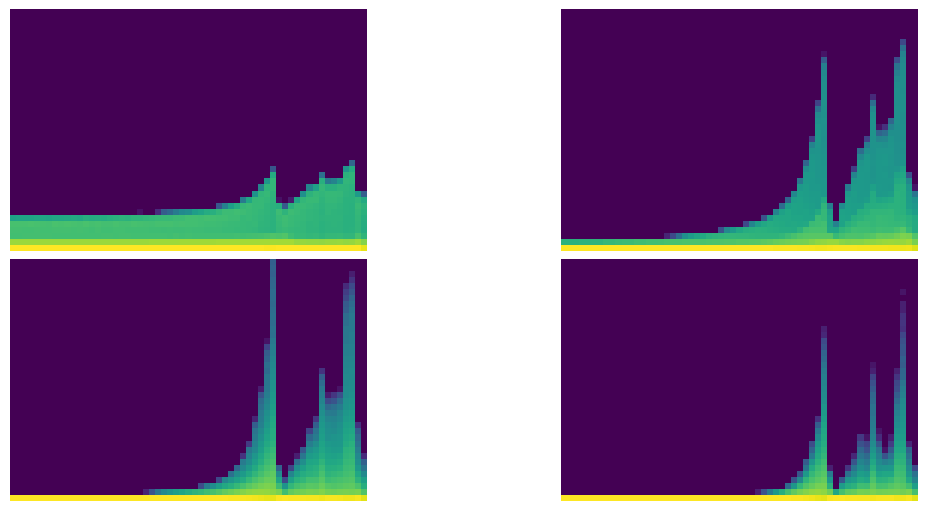

In [ ]:
astats.plot_stats()
astats.dead_chart()
astats.color_dim()

### 0.1

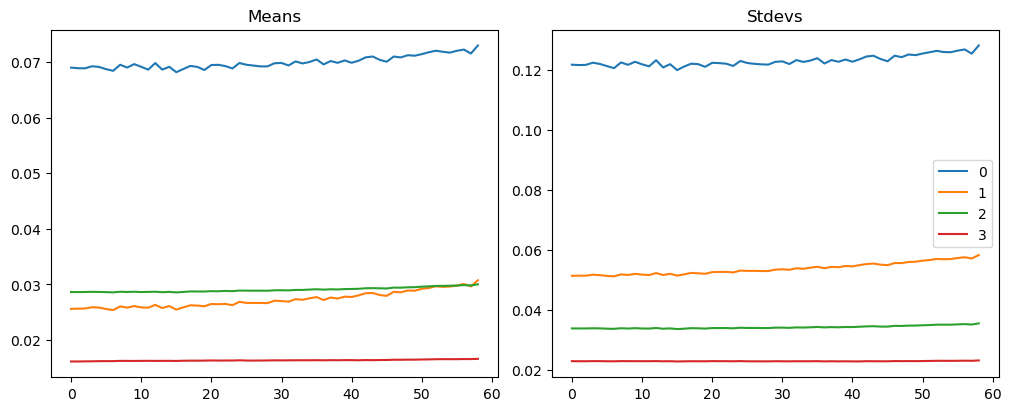

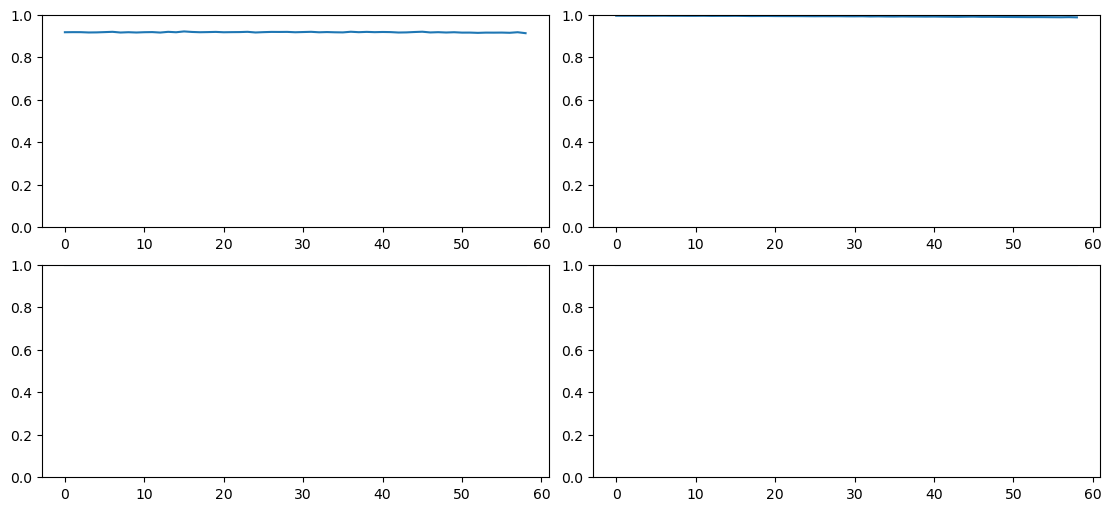

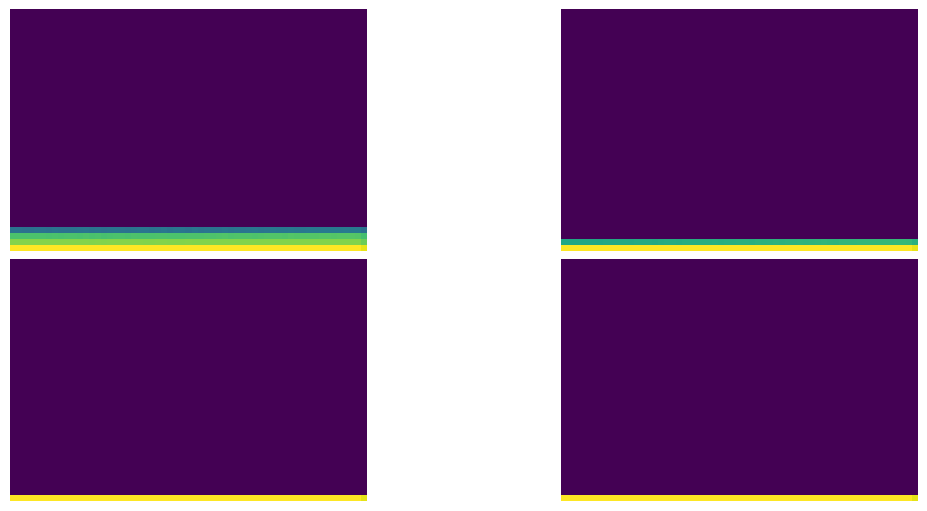

In [ ]:
astats.plot_stats()
astats.dead_chart()
astats.color_dim()

### 0.2

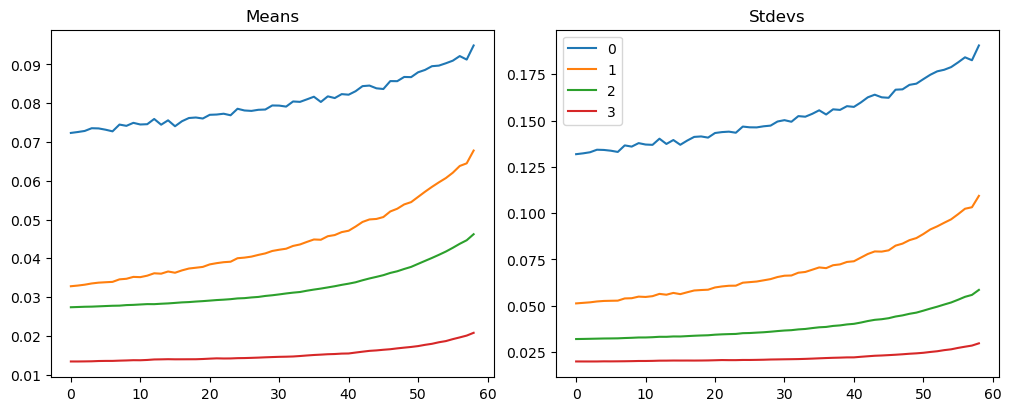

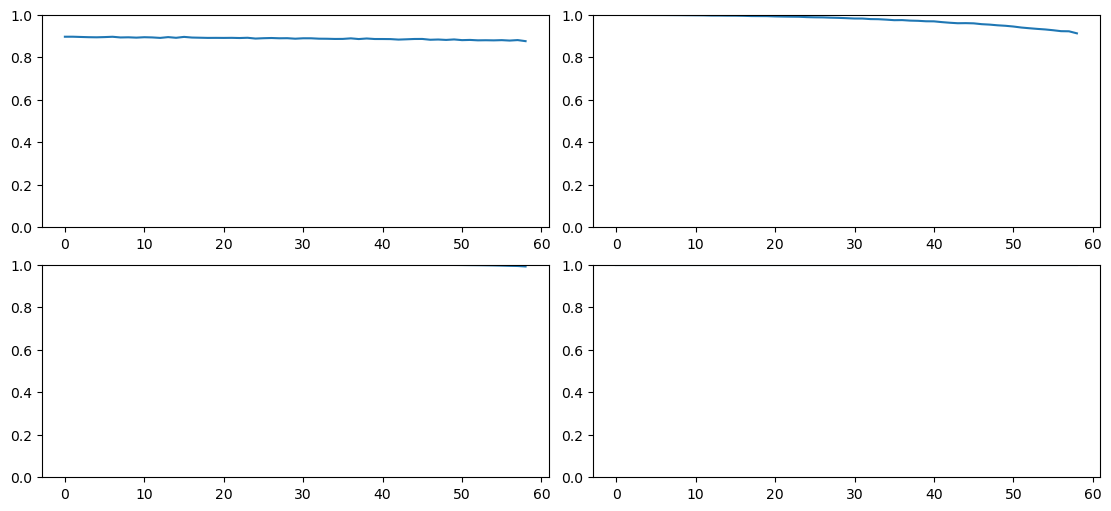

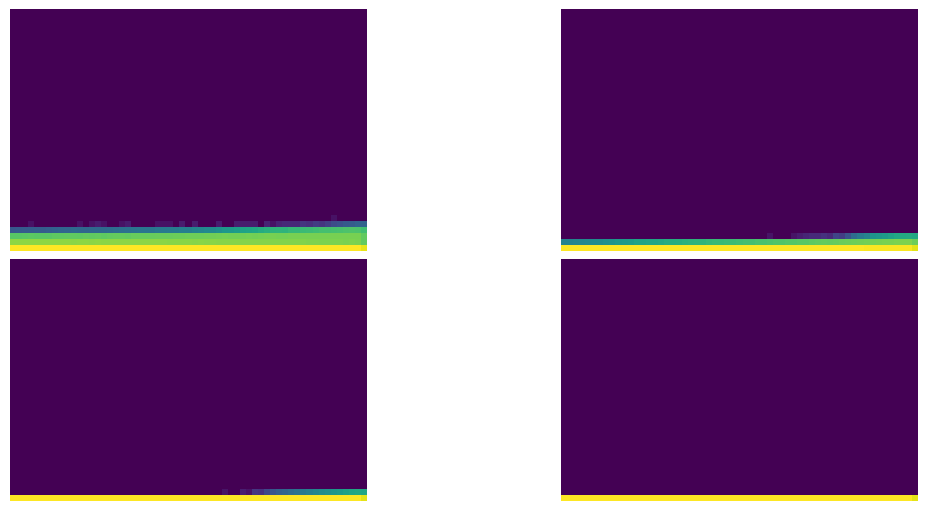

In [ ]:
astats.plot_stats()
astats.dead_chart()
astats.color_dim()